In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import math
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score

In [2]:

# these two files are large, and it may take a while to read...
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [3]:
print(len(counts))
print(len(weather))
print(counts[:5])
print(weather[:5])

61296
1340
                     Fremont Bridge East Sidewalk  \
Date                                                
2019-01-01 00:00:00                           0.0   
2019-01-01 01:00:00                           2.0   
2019-01-01 02:00:00                           1.0   
2019-01-01 03:00:00                           1.0   
2019-01-01 04:00:00                           2.0   

                     Fremont Bridge West Sidewalk  
Date                                               
2019-01-01 00:00:00                           9.0  
2019-01-01 01:00:00                          22.0  
2019-01-01 02:00:00                          11.0  
2019-01-01 03:00:00                           2.0  
2019-01-01 04:00:00                           1.0  
                      STATION                                STATION_NAME  \
DATE                                                                        
2012-01-01  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2012-01-02  GHCND:USW0

In [4]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns
print(daily[:5])

             Total
Date              
2012-10-03  3521.0
2012-10-04  3475.0
2012-10-05  3148.0
2012-10-06  2006.0
2012-10-07  2142.0


In [5]:
# add an indicator about Mon - Sun
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
    
print(daily[:5])

             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun
Date                                                 
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0


In [6]:
# add an indicator about holiday
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
# replace missing data with 0
daily['holiday'].fillna(0, inplace=True)

print(daily[:5])

             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday
Date                                                          
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0


             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday  daylight_hrs
Date                                                                        
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0     11.277359
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0     11.219142
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0     11.161038
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0     11.103056
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0     11.045208


<ipython-input-7-54b73f3bae3b>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (date - pd.datetime(2000, 12, 21)).days


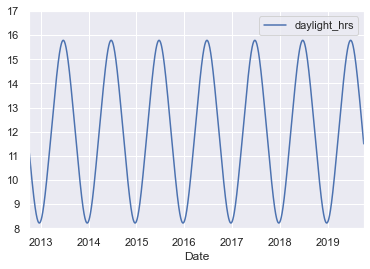

In [7]:
# This function seems crazy. The main goal is to calculate hours of daylight
# https://www.esrl.noaa.gov/gmd/grad/solcalc/sunrise.html here is an example...
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

print(daily[:5])

In [8]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
# how='left' means calling frame’s index 
# daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']], how='left', lsuffix='_left', rsuffix='_right')

daily[:5]

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0


In [9]:
# number of years passed
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [10]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

In [11]:
from sklearn.model_selection import RandomizedSearchCV
# numpy arange(1, 10, 0.1)
# RandomizedSearchCV

In [12]:
# Mark
# TODO Ridge 
# ref Linear-Regression/Regularization

In [38]:
# Kevin
# TODO Lasso
# ref Linear-Regression/Regularization
from sklearn.linear_model import Lasso
import scipy.stats
from sklearn import linear_model


lasso_model = linear_model.Lasso()
# print(model.get_params().keys())
param_dist = {'alpha': np.arange(0, 10, .001)}
lasso_model.fit(X, y)
clf = RandomizedSearchCV(lasso_model, param_distributions=param_dist, n_iter=100, random_state=0)
search = clf.fit(X, y)
lasso_alpha = search.best_params_['alpha']
print(lasso_alpha)
lasso_model = linear_model.Lasso(alpha=lasso_alpha)
lasso_model.fit(X, y)

4.859


Lasso(alpha=4.859)

In [39]:
# Matt
# K-cross fold validation (k = 10)
# ref Evaluation/Model Validation folder 
k = 10
lasso_score = cross_val_score(lasso_model, X, y, cv=k)
lasso_avg_score = lasso_score.mean()
#print(lasso_score)
print("Lasso Average Score: ",lasso_avg_score)

linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(X, y)

linear_score = cross_val_score(linear_model, X, y, cv=k)
linear_avg_score = linear_score.mean()
#print(linear_score)
print("Linear Average Score: ", linear_avg_score)

'''ridge_score = cross_val_score(ridge_model, X, y, cv=k)
ridge_avg_score = ridge_score.mean()
#print(ridge_score)
print("Ridge Average Score: ", ridge_avg_score)
'''


Lasso Average Score:  0.7707506715348998
Linear Average Score:  0.7691752923789883


'ridge_score = cross_val_score(ridge_model, X, y, cv=k)\nridge_avg_score = ridge_score.mean()\n#print(ridge_score)\nprint("Ridge Average Score: ", ridge_avg_score)\n'